<a href="https://colab.research.google.com/github/Tessellate-Imaging/Monk_Object_Detection/blob/master/application_model_zoo/Example%20-%20logo%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of contents


## 1. Installation Instructions



## 2. Use trained model to detect brand logo in images



## 3. How to train a custom detector using openlogo dataset

# Installation

 - Run these commands
     
     - git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git
     
     - cd Monk_Object_Detection/3_mxrcnn/installation
     
 - Select the right requirements file and run
 
     - cat requirements_cuda9.0.txt | xargs -n 1 -L 1 pip install

In [ ]:
! git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git

In [ ]:
# For colab use the command below
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install


# For Local systems and cloud select the right CUDA version
#! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_cuda9.0.txt | xargs -n 1 -L 1 pip install

# Use already trained model for demo

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")

In [2]:
from infer_base import *

In [ ]:
# Download trained model

In [ ]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XXu826mSe5MqTEHzJEYZpXypj7bO12Pt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1XXu826mSe5MqTEHzJEYZpXypj7bO12Pt" -O logo_trained.zip && rm -rf /tmp/cookies.txt

In [ ]:
! unzip -qq logo_trained.zip

In [3]:
class_file = set_class_list("logo_trained/classes.txt");

In [ ]:
#Model - Select the model as per number of iterations it has been trained for

In [4]:
set_model_params(model_name="vgg16", model_path="logo_trained/model_vgg16-0100.params");

In [ ]:
#Hyper Params

In [5]:
set_hyper_params(gpus="0", batch_size=1);

In [6]:
# Preprocessing

In [7]:
set_img_preproc_params(img_short_side=600, img_long_side=1000, 
                       mean=(123.68, 116.779, 103.939), std=(1.0, 1.0, 1.0));

In [ ]:
#Initalization

In [8]:
initialize_rpn_params();

In [9]:
initialize_rcnn_params();

In [ ]:
#Network

In [10]:
sym = set_network();
mod = load_model(sym);

In [ ]:
#Load Image and infer

ford
 0.998867392539978 [107.82752110026297, 141.5855894532648, 263.48839371592516, 218.17391327360403]
ford
 0.9982641339302063 [107.55577223742623, 336.6309739480891, 250.44715826072024, 388.4137359969913]
['ford\n', 0.998867392539978, [107.82752110026297, 141.5855894532648, 263.48839371592516, 218.17391327360403]]


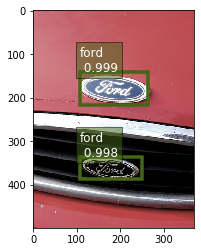

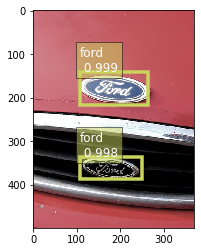

In [11]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img1.jpg", mod);

heineken
 0.9653279185295105 [278.23859375, 409.5534765625, 558.35, 821.92703125]
heineken_text
 0.9979052543640137 [295.12119140625, 568.0960546875, 559.823671875, 639.3924609375]
['heineken_text\n', 0.9979052543640137, [295.12119140625, 568.0960546875, 559.823671875, 639.3924609375]]


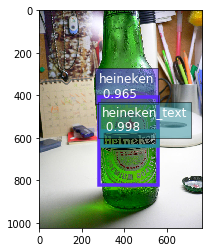

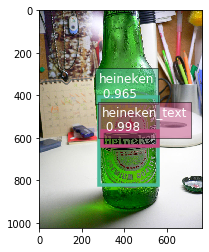

In [12]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img2.jpg", mod);

starbucks
 0.9999499320983887 [253.01642650020685, 106.14812756055602, 323.458372098871, 170.45914848515665]
['starbucks\n', 0.9999499320983887, [253.01642650020685, 106.14812756055602, 323.458372098871, 170.45914848515665]]


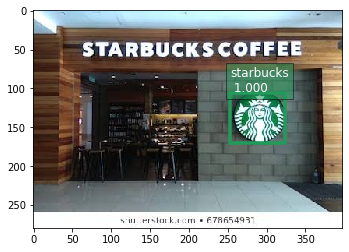

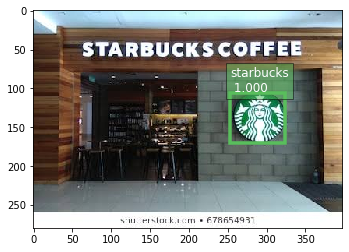

In [15]:
set_output_params(vis_thresh=0.95, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img3.jpeg", mod);

# Train you own detector

# Download Dataset

- credits: https://qmul-openlogo.github.io/

- Download the dataset from - https://qmul-openlogo.github.io/
    

In [6]:
! tar -xf openlogo.tar 

# VOC Format

## Dataset Directory Structure

    openlogo (root_dir)
          |
          |-----------JPEGImages (img_dir)
          |              |
          |              |------------------img1.jpg
          |              |------------------img2.jpg
          |              |------------------.........(and so on)
          |
          |
          |-----------Annotations (anno_dir)
          |              |
          |              |------------------img1.xml
          |              |------------------img2.xml
          |              |------------------.........(and so on)
          

        

# Desired annotation - COCO Format

## Dataset Directory Structure

    ./ (root_dir)
          |
          |------openlogo (coco_dir) 
          |         |
          |         |---JPEGImages (img_dir)
          |         |----|
          |              |-------------------img1.jpg
          |              |-------------------img2.jpg
          |              |-------------------.........(and so on)
          |
          |
          |         |---annotations (anno_dir)
          |         |----|
          |              |--------------------instances_Images.json 
          |              |--------------------classes.txt
          
          
 - instances_Train.json -> In proper COCO format
 - classes.txt          -> A list of classes in alphabetical order

# Annotation Conversion - Step 1 - VOC to Monk format

In [7]:
import os
import sys
import numpy as np
import pandas as pd

import xmltodict
import json
from tqdm.notebook import tqdm

from pycocotools.coco import COCO

In [8]:
root_dir = "openlogo/";
img_dir = "JPEGImages/";
anno_dir = "Annotations/";

In [9]:
files = os.listdir(root_dir + anno_dir);

In [10]:
combined = [];
for i in tqdm(range(len(files))):
    annoFile = root_dir + "/" + anno_dir + "/" + files[i];
    f = open(annoFile, 'r');
    my_xml = f.read();
    anno = dict(dict(xmltodict.parse(my_xml))["annotation"])
    fname = anno["filename"];
    label_str = "";
    if(type(anno["object"]) == list):
        for j in range(len(anno["object"])):
            obj = dict(anno["object"][j]);
            label = anno["object"][j]["name"];
            bbox = dict(anno["object"][j]["bndbox"])
            x1 = bbox["xmin"];
            y1 = bbox["ymin"];
            x2 = bbox["xmax"];
            y2 = bbox["ymax"];
            if(j == len(anno["object"])-1):
                label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label;
            else:        
                label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label + " ";
    else:
        obj = dict(anno["object"]);
        label = anno["object"]["name"];
        bbox = dict(anno["object"]["bndbox"])
        x1 = bbox["xmin"];
        y1 = bbox["ymin"];
        x2 = bbox["xmax"];
        y2 = bbox["ymax"];
        
        label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label;
    
    
    combined.append([fname, label_str])

In [11]:
df = pd.DataFrame(combined, columns = ['ID', 'Label']);
df.to_csv(root_dir + "/train_labels.csv", index=False);

# Annotation Conversion - Step 1 - Monk format to COCO

In [12]:
import os
import numpy as np 
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString
from tqdm import tqdm
import shutil
import json
import pandas as pd

In [12]:
# Provide details on directory in Monk Format

In [13]:
root = "openlogo";
img_dir = "JPEGImages/";
anno_file = "train_labels.csv";

In [14]:
# Need not change anything below

In [15]:
dataset_path = root;
images_folder = root + "/" + img_dir;
annotations_path = root + "/annotations/";

In [16]:
if not os.path.isdir(annotations_path):
    os.mkdir(annotations_path)
    
input_images_folder = images_folder;
input_annotations_path = root + "/" + anno_file;

In [17]:
output_dataset_path = root;
output_image_folder = input_images_folder;
output_annotation_folder = annotations_path;

tmp = img_dir.replace("/", "");
output_annotation_file = output_annotation_folder + "/instances_" + tmp + ".json";
output_classes_file = output_annotation_folder + "/classes.txt";

In [18]:
if not os.path.isdir(output_annotation_folder):
    os.mkdir(output_annotation_folder);

In [19]:
df = pd.read_csv(input_annotations_path);
columns = df.columns

In [20]:
delimiter = " ";

In [21]:
list_dict = [];
anno = [];
for i in range(len(df)):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    for j in range(len(tmp)//5):
        label = tmp[j*5+4];
        if(label not in anno):
            anno.append(label);
    anno = sorted(anno)
    
for i in tqdm(range(len(anno))):
    tmp = {};
    tmp["supercategory"] = "master";
    tmp["id"] = i;
    tmp["name"] = anno[i];
    list_dict.append(tmp);

anno_f = open(output_classes_file, 'w');
for i in range(len(anno)):
    anno_f.write(anno[i] + "\n");
anno_f.close();

100%|██████████| 352/352 [00:00<00:00, 722660.31it/s]


In [22]:
coco_data = {};
coco_data["type"] = "instances";
coco_data["images"] = [];
coco_data["annotations"] = [];
coco_data["categories"] = list_dict;
image_id = 0;
annotation_id = 0;


for i in tqdm(range(len(df))):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    image_in_path = input_images_folder + "/" + img_name;
    img = cv2.imread(image_in_path, 1);
    h, w, c = img.shape;

    images_tmp = {};
    images_tmp["file_name"] = img_name;
    images_tmp["height"] = h;
    images_tmp["width"] = w;
    images_tmp["id"] = image_id;
    coco_data["images"].append(images_tmp);
    

    for j in range(len(tmp)//5):
        x1 = int(tmp[j*5+0]);
        y1 = int(tmp[j*5+1]);
        x2 = int(tmp[j*5+2]);
        y2 = int(tmp[j*5+3]);
        label = tmp[j*5+4];
        annotations_tmp = {};
        annotations_tmp["id"] = annotation_id;
        annotation_id += 1;
        annotations_tmp["image_id"] = image_id;
        annotations_tmp["segmentation"] = [];
        annotations_tmp["ignore"] = 0;
        annotations_tmp["area"] = (x2-x1)*(y2-y1);
        annotations_tmp["iscrowd"] = 0;
        annotations_tmp["bbox"] = [x1, y1, x2-x1, y2-y1];
        annotations_tmp["category_id"] = anno.index(label);

        coco_data["annotations"].append(annotations_tmp)
    image_id += 1;

outfile =  open(output_annotation_file, 'w');
json_str = json.dumps(coco_data, indent=4);
outfile.write(json_str);
outfile.close();

100%|██████████| 27083/27083 [06:46<00:00, 66.64it/s] 


# Training

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")

In [2]:
from train_base import *

In [3]:
# Dataset params

In [4]:
root_dir = "./";
coco_dir = "openlogo";
img_dir = "JPEGImages"; 

In [5]:
set_dataset_params(root_dir=root_dir, 
                   coco_dir=coco_dir, imageset=img_dir);

In [6]:
# Model Type

In [7]:
set_model_params(model_name="vgg16");

In [8]:
# Hyper Params

In [9]:
set_hyper_params(gpus="0", lr=0.001, lr_decay_epoch="1", epochs=2, batch_size=1);

In [10]:
set_output_params(log_interval=100, save_prefix="model_vgg16");

In [11]:
# Preprocessing params

In [12]:
set_img_preproc_params(img_short_side=600, img_long_side=1000, 
                       mean=(123.68, 116.779, 103.939), std=(1.0, 1.0, 1.0));

In [13]:
# Initialize params

In [14]:
initialize_rpn_params();

In [15]:
initialize_rcnn_params();

In [16]:
# Remove caches if any

In [17]:
if os.path.isdir("./cache/"):
    os.system("rm -r ./cache/")

In [18]:
# Invoke Dataloader

In [19]:
roidb = set_dataset();

INFO:root:computing cache ./cache/coco_JPEGImages_roidb.pkl


loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


INFO:root:saving cache ./cache/coco_JPEGImages_roidb.pkl
INFO:root:coco_JPEGImages num_images 27083
INFO:root:filter roidb: 27083 -> 27083
INFO:root:coco_JPEGImages append flipped images to roidb


In [20]:
#Network

In [21]:
sym = set_network();

In [22]:
# Train

In [ ]:
train(sym, roidb);

INFO:root:max input shape
{'bbox_target': (1, 36, 62, 62),
 'bbox_weight': (1, 36, 62, 62),
 'data': (1, 3, 1000, 1000),
 'gt_boxes': (1, 100, 5),
 'im_info': (1, 3),
 'label': (1, 1, 558, 62)}
INFO:root:max output shape
{'bbox_loss_reshape_output': (1, 128, 1412),
 'blockgrad0_output': (1, 128),
 'cls_prob_reshape_output': (1, 128, 353),
 'rpn_bbox_loss_output': (1, 36, 62, 62),
 'rpn_cls_prob_output': (1, 2, 558, 62)}
INFO:root:locking params
['conv1_1_weight',
 'conv1_1_bias',
 'conv1_2_weight',
 'conv1_2_bias',
 'conv2_1_weight',
 'conv2_1_bias',
 'conv2_2_weight',
 'conv2_2_bias',
 'conv3_1_weight',
 'conv3_1_bias',
 'conv3_2_weight',
 'conv3_2_bias',
 'conv3_3_weight',
 'conv3_3_bias',
 'conv4_1_weight',
 'conv4_1_bias',
 'conv4_2_weight',
 'conv4_2_bias',
 'conv4_3_weight',
 'conv4_3_bias']
INFO:root:lr 0.001000 lr_epoch_diff [1] lr_iters [54166]
INFO:root:Epoch[0] Batch [0-100]	Speed: 4.87 samples/sec	RPNAcc=0.954053	RPNLogLoss=0.188433	RPNL1Loss=1.109752	RCNNAcc=0.921720	RCNNL

INFO:root:Epoch[0] Batch [0-4400]	Speed: 4.18 samples/sec	RPNAcc=0.971239	RPNLogLoss=0.084898	RPNL1Loss=0.754704	RCNNAcc=0.923251	RCNNLogLoss=0.518153	RCNNL1Loss=2.155491
INFO:root:Epoch[0] Batch [0-4500]	Speed: 4.67 samples/sec	RPNAcc=0.971371	RPNLogLoss=0.084474	RPNL1Loss=0.751906	RCNNAcc=0.923279	RCNNLogLoss=0.516136	RCNNL1Loss=2.154363
INFO:root:Epoch[0] Batch [0-4600]	Speed: 4.49 samples/sec	RPNAcc=0.971418	RPNLogLoss=0.084057	RPNL1Loss=0.749997	RCNNAcc=0.923011	RCNNLogLoss=0.515565	RCNNL1Loss=2.152523
INFO:root:Epoch[0] Batch [0-4700]	Speed: 4.28 samples/sec	RPNAcc=0.971599	RPNLogLoss=0.083432	RPNL1Loss=0.746785	RCNNAcc=0.922937	RCNNLogLoss=0.514047	RCNNL1Loss=2.148615
INFO:root:Epoch[0] Batch [0-4800]	Speed: 4.35 samples/sec	RPNAcc=0.971719	RPNLogLoss=0.083064	RPNL1Loss=0.744632	RCNNAcc=0.922754	RCNNLogLoss=0.513871	RCNNL1Loss=2.148302
INFO:root:Epoch[0] Batch [0-4900]	Speed: 4.30 samples/sec	RPNAcc=0.971845	RPNLogLoss=0.082538	RPNL1Loss=0.741377	RCNNAcc=0.922725	RCNNLogLoss=0.5

INFO:root:Epoch[0] Batch [0-9200]	Speed: 4.60 samples/sec	RPNAcc=0.973246	RPNLogLoss=0.077234	RPNL1Loss=0.677445	RCNNAcc=0.916487	RCNNLogLoss=0.515018	RCNNL1Loss=2.069743
INFO:root:Epoch[0] Batch [0-9300]	Speed: 4.43 samples/sec	RPNAcc=0.973287	RPNLogLoss=0.077051	RPNL1Loss=0.676074	RCNNAcc=0.916523	RCNNLogLoss=0.514050	RCNNL1Loss=2.068968
INFO:root:Epoch[0] Batch [0-9400]	Speed: 3.99 samples/sec	RPNAcc=0.973329	RPNLogLoss=0.076874	RPNL1Loss=0.674237	RCNNAcc=0.916405	RCNNLogLoss=0.514276	RCNNL1Loss=2.067416
INFO:root:Epoch[0] Batch [0-9500]	Speed: 4.20 samples/sec	RPNAcc=0.973358	RPNLogLoss=0.076728	RPNL1Loss=0.672808	RCNNAcc=0.916315	RCNNLogLoss=0.513689	RCNNL1Loss=2.065432
INFO:root:Epoch[0] Batch [0-9600]	Speed: 4.19 samples/sec	RPNAcc=0.973388	RPNLogLoss=0.076578	RPNL1Loss=0.670562	RCNNAcc=0.916072	RCNNLogLoss=0.514158	RCNNL1Loss=2.064163
INFO:root:Epoch[0] Batch [0-9700]	Speed: 4.66 samples/sec	RPNAcc=0.973428	RPNLogLoss=0.076449	RPNL1Loss=0.668670	RCNNAcc=0.916048	RCNNLogLoss=0.5

INFO:root:Epoch[0] Batch [0-14000]	Speed: 4.67 samples/sec	RPNAcc=0.975013	RPNLogLoss=0.071766	RPNL1Loss=0.618785	RCNNAcc=0.917205	RCNNLogLoss=0.485704	RCNNL1Loss=1.982784
INFO:root:Epoch[0] Batch [0-14100]	Speed: 4.71 samples/sec	RPNAcc=0.975083	RPNLogLoss=0.071537	RPNL1Loss=0.618150	RCNNAcc=0.917242	RCNNLogLoss=0.484837	RCNNL1Loss=1.981140
INFO:root:Epoch[0] Batch [0-14200]	Speed: 5.04 samples/sec	RPNAcc=0.975095	RPNLogLoss=0.071516	RPNL1Loss=0.617234	RCNNAcc=0.917270	RCNNLogLoss=0.484156	RCNNL1Loss=1.979845
INFO:root:Epoch[0] Batch [0-14300]	Speed: 5.00 samples/sec	RPNAcc=0.975153	RPNLogLoss=0.071378	RPNL1Loss=0.616116	RCNNAcc=0.917303	RCNNLogLoss=0.483411	RCNNL1Loss=1.977771
INFO:root:Epoch[0] Batch [0-14400]	Speed: 4.65 samples/sec	RPNAcc=0.975176	RPNLogLoss=0.071290	RPNL1Loss=0.614784	RCNNAcc=0.917267	RCNNLogLoss=0.483355	RCNNL1Loss=1.977115
INFO:root:Epoch[0] Batch [0-14500]	Speed: 4.68 samples/sec	RPNAcc=0.975210	RPNLogLoss=0.071195	RPNL1Loss=0.613394	RCNNAcc=0.917224	RCNNLogLo

INFO:root:Epoch[0] Batch [0-18800]	Speed: 4.75 samples/sec	RPNAcc=0.976324	RPNLogLoss=0.068131	RPNL1Loss=0.579795	RCNNAcc=0.918373	RCNNLogLoss=0.462677	RCNNL1Loss=1.911352
INFO:root:Epoch[0] Batch [0-18900]	Speed: 4.79 samples/sec	RPNAcc=0.976374	RPNLogLoss=0.068007	RPNL1Loss=0.579395	RCNNAcc=0.918526	RCNNLogLoss=0.461664	RCNNL1Loss=1.909119
INFO:root:Epoch[0] Batch [0-19000]	Speed: 4.81 samples/sec	RPNAcc=0.976383	RPNLogLoss=0.068002	RPNL1Loss=0.579209	RCNNAcc=0.918590	RCNNLogLoss=0.460974	RCNNL1Loss=1.908337
INFO:root:Epoch[0] Batch [0-19100]	Speed: 5.05 samples/sec	RPNAcc=0.976423	RPNLogLoss=0.067887	RPNL1Loss=0.578485	RCNNAcc=0.918683	RCNNLogLoss=0.460130	RCNNL1Loss=1.907164
INFO:root:Epoch[0] Batch [0-19200]	Speed: 4.86 samples/sec	RPNAcc=0.976467	RPNLogLoss=0.067794	RPNL1Loss=0.577771	RCNNAcc=0.918731	RCNNLogLoss=0.459553	RCNNL1Loss=1.906384
INFO:root:Epoch[0] Batch [0-19300]	Speed: 4.56 samples/sec	RPNAcc=0.976470	RPNLogLoss=0.067761	RPNL1Loss=0.577636	RCNNAcc=0.918752	RCNNLogLo

INFO:root:Epoch[0] Batch [0-23600]	Speed: 4.66 samples/sec	RPNAcc=0.977341	RPNLogLoss=0.065051	RPNL1Loss=0.555172	RCNNAcc=0.919977	RCNNLogLoss=0.441527	RCNNL1Loss=1.838170
INFO:root:Epoch[0] Batch [0-23700]	Speed: 4.64 samples/sec	RPNAcc=0.977375	RPNLogLoss=0.064974	RPNL1Loss=0.554643	RCNNAcc=0.920061	RCNNLogLoss=0.440865	RCNNL1Loss=1.836634
INFO:root:Epoch[0] Batch [0-23800]	Speed: 4.75 samples/sec	RPNAcc=0.977385	RPNLogLoss=0.064946	RPNL1Loss=0.554191	RCNNAcc=0.920085	RCNNLogLoss=0.440555	RCNNL1Loss=1.835558
INFO:root:Epoch[0] Batch [0-23900]	Speed: 4.67 samples/sec	RPNAcc=0.977414	RPNLogLoss=0.064846	RPNL1Loss=0.553771	RCNNAcc=0.920111	RCNNLogLoss=0.440102	RCNNL1Loss=1.834435
INFO:root:Epoch[0] Batch [0-24000]	Speed: 4.87 samples/sec	RPNAcc=0.977440	RPNLogLoss=0.064766	RPNL1Loss=0.553954	RCNNAcc=0.920225	RCNNLogLoss=0.439335	RCNNL1Loss=1.832651
INFO:root:Epoch[0] Batch [0-24100]	Speed: 5.10 samples/sec	RPNAcc=0.977461	RPNLogLoss=0.064686	RPNL1Loss=0.553235	RCNNAcc=0.920306	RCNNLogLo

INFO:root:Epoch[0] Batch [0-28400]	Speed: 4.67 samples/sec	RPNAcc=0.978173	RPNLogLoss=0.062643	RPNL1Loss=0.538666	RCNNAcc=0.921869	RCNNLogLoss=0.422120	RCNNL1Loss=1.777406
INFO:root:Epoch[0] Batch [0-28500]	Speed: 4.69 samples/sec	RPNAcc=0.978190	RPNLogLoss=0.062589	RPNL1Loss=0.538311	RCNNAcc=0.921875	RCNNLogLoss=0.421879	RCNNL1Loss=1.776389
INFO:root:Epoch[0] Batch [0-28600]	Speed: 5.14 samples/sec	RPNAcc=0.978199	RPNLogLoss=0.062591	RPNL1Loss=0.538222	RCNNAcc=0.921926	RCNNLogLoss=0.421429	RCNNL1Loss=1.775170
INFO:root:Epoch[0] Batch [0-28700]	Speed: 4.96 samples/sec	RPNAcc=0.978204	RPNLogLoss=0.062568	RPNL1Loss=0.538003	RCNNAcc=0.921882	RCNNLogLoss=0.421450	RCNNL1Loss=1.773920
INFO:root:Epoch[0] Batch [0-28800]	Speed: 4.22 samples/sec	RPNAcc=0.978221	RPNLogLoss=0.062537	RPNL1Loss=0.537734	RCNNAcc=0.921872	RCNNLogLoss=0.421390	RCNNL1Loss=1.772384
INFO:root:Epoch[0] Batch [0-28900]	Speed: 4.83 samples/sec	RPNAcc=0.978222	RPNLogLoss=0.062518	RPNL1Loss=0.537469	RCNNAcc=0.921935	RCNNLogLo

INFO:root:Epoch[0] Batch [0-33200]	Speed: 4.37 samples/sec	RPNAcc=0.978733	RPNLogLoss=0.060806	RPNL1Loss=0.524380	RCNNAcc=0.922961	RCNNLogLoss=0.408110	RCNNL1Loss=1.723196
INFO:root:Epoch[0] Batch [0-33300]	Speed: 4.86 samples/sec	RPNAcc=0.978761	RPNLogLoss=0.060732	RPNL1Loss=0.524230	RCNNAcc=0.922991	RCNNLogLoss=0.407898	RCNNL1Loss=1.722443
INFO:root:Epoch[0] Batch [0-33400]	Speed: 4.57 samples/sec	RPNAcc=0.978761	RPNLogLoss=0.060733	RPNL1Loss=0.524023	RCNNAcc=0.923016	RCNNLogLoss=0.407627	RCNNL1Loss=1.721652
INFO:root:Epoch[0] Batch [0-33500]	Speed: 4.67 samples/sec	RPNAcc=0.978773	RPNLogLoss=0.060691	RPNL1Loss=0.523762	RCNNAcc=0.922995	RCNNLogLoss=0.407679	RCNNL1Loss=1.721216
INFO:root:Epoch[0] Batch [0-33600]	Speed: 4.57 samples/sec	RPNAcc=0.978772	RPNLogLoss=0.060666	RPNL1Loss=0.523418	RCNNAcc=0.922990	RCNNLogLoss=0.407527	RCNNL1Loss=1.720310
INFO:root:Epoch[0] Batch [0-33700]	Speed: 4.95 samples/sec	RPNAcc=0.978788	RPNLogLoss=0.060627	RPNL1Loss=0.523442	RCNNAcc=0.923004	RCNNLogLo

INFO:root:Epoch[0] Batch [0-38000]	Speed: 5.05 samples/sec	RPNAcc=0.979259	RPNLogLoss=0.059330	RPNL1Loss=0.511411	RCNNAcc=0.923714	RCNNLogLoss=0.397591	RCNNL1Loss=1.678893
INFO:root:Epoch[0] Batch [0-38100]	Speed: 4.61 samples/sec	RPNAcc=0.979276	RPNLogLoss=0.059288	RPNL1Loss=0.511046	RCNNAcc=0.923763	RCNNLogLoss=0.397286	RCNNL1Loss=1.677641
INFO:root:Epoch[0] Batch [0-38200]	Speed: 4.63 samples/sec	RPNAcc=0.979283	RPNLogLoss=0.059276	RPNL1Loss=0.510927	RCNNAcc=0.923777	RCNNLogLoss=0.397095	RCNNL1Loss=1.676752
INFO:root:Epoch[0] Batch [0-38300]	Speed: 4.73 samples/sec	RPNAcc=0.979286	RPNLogLoss=0.059259	RPNL1Loss=0.510579	RCNNAcc=0.923805	RCNNLogLoss=0.396805	RCNNL1Loss=1.675865
INFO:root:Epoch[0] Batch [0-38400]	Speed: 4.67 samples/sec	RPNAcc=0.979301	RPNLogLoss=0.059202	RPNL1Loss=0.510304	RCNNAcc=0.923823	RCNNLogLoss=0.396569	RCNNL1Loss=1.675059
INFO:root:Epoch[0] Batch [0-38500]	Speed: 4.62 samples/sec	RPNAcc=0.979314	RPNLogLoss=0.059161	RPNL1Loss=0.509982	RCNNAcc=0.923864	RCNNLogLo

INFO:root:Epoch[0] Batch [0-42800]	Speed: 4.82 samples/sec	RPNAcc=0.979749	RPNLogLoss=0.057942	RPNL1Loss=0.499241	RCNNAcc=0.925294	RCNNLogLoss=0.384313	RCNNL1Loss=1.639755
INFO:root:Epoch[0] Batch [0-42900]	Speed: 4.82 samples/sec	RPNAcc=0.979760	RPNLogLoss=0.057942	RPNL1Loss=0.498964	RCNNAcc=0.925344	RCNNLogLoss=0.383966	RCNNL1Loss=1.638916
INFO:root:Epoch[0] Batch [0-43000]	Speed: 4.76 samples/sec	RPNAcc=0.979774	RPNLogLoss=0.057896	RPNL1Loss=0.498705	RCNNAcc=0.925376	RCNNLogLoss=0.383681	RCNNL1Loss=1.637864
INFO:root:Epoch[0] Batch [0-43100]	Speed: 4.77 samples/sec	RPNAcc=0.979772	RPNLogLoss=0.057897	RPNL1Loss=0.498464	RCNNAcc=0.925428	RCNNLogLoss=0.383368	RCNNL1Loss=1.637065
INFO:root:Epoch[0] Batch [0-43200]	Speed: 4.76 samples/sec	RPNAcc=0.979780	RPNLogLoss=0.057874	RPNL1Loss=0.498231	RCNNAcc=0.925463	RCNNLogLoss=0.383092	RCNNL1Loss=1.636156
INFO:root:Epoch[0] Batch [0-43300]	Speed: 4.58 samples/sec	RPNAcc=0.979782	RPNLogLoss=0.057884	RPNL1Loss=0.498232	RCNNAcc=0.925482	RCNNLogLo

INFO:root:Epoch[0] Batch [0-47600]	Speed: 4.66 samples/sec	RPNAcc=0.980184	RPNLogLoss=0.056595	RPNL1Loss=0.489917	RCNNAcc=0.926962	RCNNLogLoss=0.371188	RCNNL1Loss=1.605408
INFO:root:Epoch[0] Batch [0-47700]	Speed: 4.74 samples/sec	RPNAcc=0.980196	RPNLogLoss=0.056559	RPNL1Loss=0.489796	RCNNAcc=0.926987	RCNNLogLoss=0.371024	RCNNL1Loss=1.604924
INFO:root:Epoch[0] Batch [0-47800]	Speed: 4.82 samples/sec	RPNAcc=0.980202	RPNLogLoss=0.056538	RPNL1Loss=0.489537	RCNNAcc=0.927012	RCNNLogLoss=0.370823	RCNNL1Loss=1.604324
INFO:root:Epoch[0] Batch [0-47900]	Speed: 4.77 samples/sec	RPNAcc=0.980211	RPNLogLoss=0.056511	RPNL1Loss=0.489589	RCNNAcc=0.927030	RCNNLogLoss=0.370657	RCNNL1Loss=1.603579
INFO:root:Epoch[0] Batch [0-48000]	Speed: 4.29 samples/sec	RPNAcc=0.980215	RPNLogLoss=0.056488	RPNL1Loss=0.489512	RCNNAcc=0.927037	RCNNLogLoss=0.370501	RCNNL1Loss=1.602896
INFO:root:Epoch[0] Batch [0-48100]	Speed: 4.50 samples/sec	RPNAcc=0.980224	RPNLogLoss=0.056455	RPNL1Loss=0.489431	RCNNAcc=0.927063	RCNNLogLo

INFO:root:Epoch[0] Batch [0-52400]	Speed: 5.04 samples/sec	RPNAcc=0.980609	RPNLogLoss=0.055313	RPNL1Loss=0.482472	RCNNAcc=0.928449	RCNNLogLoss=0.359550	RCNNL1Loss=1.573516
INFO:root:Epoch[0] Batch [0-52500]	Speed: 4.86 samples/sec	RPNAcc=0.980621	RPNLogLoss=0.055287	RPNL1Loss=0.482325	RCNNAcc=0.928488	RCNNLogLoss=0.359260	RCNNL1Loss=1.572897
INFO:root:Epoch[0] Batch [0-52600]	Speed: 4.79 samples/sec	RPNAcc=0.980637	RPNLogLoss=0.055240	RPNL1Loss=0.482153	RCNNAcc=0.928535	RCNNLogLoss=0.358974	RCNNL1Loss=1.572208
INFO:root:Epoch[0] Batch [0-52700]	Speed: 4.62 samples/sec	RPNAcc=0.980644	RPNLogLoss=0.055213	RPNL1Loss=0.482008	RCNNAcc=0.928588	RCNNLogLoss=0.358644	RCNNL1Loss=1.571660
INFO:root:Epoch[0] Batch [0-52800]	Speed: 4.77 samples/sec	RPNAcc=0.980653	RPNLogLoss=0.055186	RPNL1Loss=0.481778	RCNNAcc=0.928624	RCNNLogLoss=0.358394	RCNNL1Loss=1.570924
INFO:root:Epoch[0] Batch [0-52900]	Speed: 4.67 samples/sec	RPNAcc=0.980659	RPNLogLoss=0.055163	RPNL1Loss=0.481522	RCNNAcc=0.928669	RCNNLogLo

INFO:root:Epoch[1] Batch [0-2900]	Speed: 4.87 samples/sec	RPNAcc=0.985400	RPNLogLoss=0.039995	RPNL1Loss=0.381603	RCNNAcc=0.945620	RCNNLogLoss=0.227010	RCNNL1Loss=1.120094
INFO:root:Epoch[1] Batch [0-3000]	Speed: 4.92 samples/sec	RPNAcc=0.985505	RPNLogLoss=0.039704	RPNL1Loss=0.381062	RCNNAcc=0.945807	RCNNLogLoss=0.225902	RCNNL1Loss=1.119191
INFO:root:Epoch[1] Batch [0-3100]	Speed: 4.82 samples/sec	RPNAcc=0.985502	RPNLogLoss=0.039763	RPNL1Loss=0.380202	RCNNAcc=0.945862	RCNNLogLoss=0.225666	RCNNL1Loss=1.117947
INFO:root:Epoch[1] Batch [0-3200]	Speed: 4.75 samples/sec	RPNAcc=0.985588	RPNLogLoss=0.039622	RPNL1Loss=0.379516	RCNNAcc=0.945818	RCNNLogLoss=0.226264	RCNNL1Loss=1.118139
INFO:root:Epoch[1] Batch [0-3300]	Speed: 4.92 samples/sec	RPNAcc=0.985584	RPNLogLoss=0.039583	RPNL1Loss=0.377681	RCNNAcc=0.945968	RCNNLogLoss=0.225461	RCNNL1Loss=1.115576
INFO:root:Epoch[1] Batch [0-3400]	Speed: 4.97 samples/sec	RPNAcc=0.985537	RPNLogLoss=0.039733	RPNL1Loss=0.374047	RCNNAcc=0.946234	RCNNLogLoss=0.2

INFO:root:Epoch[1] Batch [0-7700]	Speed: 4.91 samples/sec	RPNAcc=0.985675	RPNLogLoss=0.038775	RPNL1Loss=0.356550	RCNNAcc=0.946605	RCNNLogLoss=0.219390	RCNNL1Loss=1.064545
INFO:root:Epoch[1] Batch [0-7800]	Speed: 4.67 samples/sec	RPNAcc=0.985669	RPNLogLoss=0.038762	RPNL1Loss=0.356910	RCNNAcc=0.946543	RCNNLogLoss=0.219459	RCNNL1Loss=1.065457
INFO:root:Epoch[1] Batch [0-7900]	Speed: 4.64 samples/sec	RPNAcc=0.985635	RPNLogLoss=0.038873	RPNL1Loss=0.356931	RCNNAcc=0.946372	RCNNLogLoss=0.219963	RCNNL1Loss=1.065470
INFO:root:Epoch[1] Batch [0-8000]	Speed: 4.75 samples/sec	RPNAcc=0.985656	RPNLogLoss=0.038815	RPNL1Loss=0.356282	RCNNAcc=0.946325	RCNNLogLoss=0.220054	RCNNL1Loss=1.063804
INFO:root:Epoch[1] Batch [0-8100]	Speed: 4.79 samples/sec	RPNAcc=0.985680	RPNLogLoss=0.038794	RPNL1Loss=0.356169	RCNNAcc=0.946347	RCNNLogLoss=0.219863	RCNNL1Loss=1.062720
INFO:root:Epoch[1] Batch [0-8200]	Speed: 4.78 samples/sec	RPNAcc=0.985703	RPNLogLoss=0.038756	RPNL1Loss=0.356236	RCNNAcc=0.946441	RCNNLogLoss=0.2

INFO:root:Epoch[1] Batch [0-12500]	Speed: 4.87 samples/sec	RPNAcc=0.986067	RPNLogLoss=0.037783	RPNL1Loss=0.348695	RCNNAcc=0.947819	RCNNLogLoss=0.211433	RCNNL1Loss=1.029604
INFO:root:Epoch[1] Batch [0-12600]	Speed: 4.55 samples/sec	RPNAcc=0.986064	RPNLogLoss=0.037781	RPNL1Loss=0.348190	RCNNAcc=0.947724	RCNNLogLoss=0.211875	RCNNL1Loss=1.029039
INFO:root:Epoch[1] Batch [0-12700]	Speed: 4.98 samples/sec	RPNAcc=0.986064	RPNLogLoss=0.037745	RPNL1Loss=0.347620	RCNNAcc=0.947764	RCNNLogLoss=0.211769	RCNNL1Loss=1.028030
INFO:root:Epoch[1] Batch [0-12800]	Speed: 4.94 samples/sec	RPNAcc=0.986082	RPNLogLoss=0.037688	RPNL1Loss=0.347623	RCNNAcc=0.947742	RCNNLogLoss=0.211890	RCNNL1Loss=1.028259
INFO:root:Epoch[1] Batch [0-12900]	Speed: 4.79 samples/sec	RPNAcc=0.986084	RPNLogLoss=0.037675	RPNL1Loss=0.348212	RCNNAcc=0.947751	RCNNLogLoss=0.211782	RCNNL1Loss=1.027414
INFO:root:Epoch[1] Batch [0-13000]	Speed: 4.68 samples/sec	RPNAcc=0.986090	RPNLogLoss=0.037638	RPNL1Loss=0.347959	RCNNAcc=0.947788	RCNNLogLo

INFO:root:Epoch[1] Batch [0-17300]	Speed: 4.59 samples/sec	RPNAcc=0.986490	RPNLogLoss=0.036555	RPNL1Loss=0.339762	RCNNAcc=0.949263	RCNNLogLoss=0.204827	RCNNL1Loss=1.012281
INFO:root:Epoch[1] Batch [0-17400]	Speed: 4.92 samples/sec	RPNAcc=0.986497	RPNLogLoss=0.036537	RPNL1Loss=0.339757	RCNNAcc=0.949262	RCNNLogLoss=0.204908	RCNNL1Loss=1.012812
INFO:root:Epoch[1] Batch [0-17500]	Speed: 4.96 samples/sec	RPNAcc=0.986518	RPNLogLoss=0.036494	RPNL1Loss=0.339614	RCNNAcc=0.949264	RCNNLogLoss=0.204843	RCNNL1Loss=1.012815
INFO:root:Epoch[1] Batch [0-17600]	Speed: 5.02 samples/sec	RPNAcc=0.986510	RPNLogLoss=0.036515	RPNL1Loss=0.339307	RCNNAcc=0.949323	RCNNLogLoss=0.204469	RCNNL1Loss=1.012380
INFO:root:Epoch[1] Batch [0-17700]	Speed: 4.68 samples/sec	RPNAcc=0.986527	RPNLogLoss=0.036468	RPNL1Loss=0.339026	RCNNAcc=0.949323	RCNNLogLoss=0.204428	RCNNL1Loss=1.011666
INFO:root:Epoch[1] Batch [0-17800]	Speed: 4.72 samples/sec	RPNAcc=0.986527	RPNLogLoss=0.036469	RPNL1Loss=0.338935	RCNNAcc=0.949340	RCNNLogLo

INFO:root:Epoch[1] Batch [0-22100]	Speed: 4.68 samples/sec	RPNAcc=0.986779	RPNLogLoss=0.035568	RPNL1Loss=0.336081	RCNNAcc=0.950545	RCNNLogLoss=0.197796	RCNNL1Loss=0.996897
INFO:root:Epoch[1] Batch [0-22200]	Speed: 4.38 samples/sec	RPNAcc=0.986797	RPNLogLoss=0.035519	RPNL1Loss=0.336002	RCNNAcc=0.950590	RCNNLogLoss=0.197536	RCNNL1Loss=0.996362
INFO:root:Epoch[1] Batch [0-22300]	Speed: 4.68 samples/sec	RPNAcc=0.986793	RPNLogLoss=0.035538	RPNL1Loss=0.336034	RCNNAcc=0.950583	RCNNLogLoss=0.197475	RCNNL1Loss=0.996065
INFO:root:Epoch[1] Batch [0-22400]	Speed: 4.75 samples/sec	RPNAcc=0.986806	RPNLogLoss=0.035510	RPNL1Loss=0.335790	RCNNAcc=0.950581	RCNNLogLoss=0.197476	RCNNL1Loss=0.995827
INFO:root:Epoch[1] Batch [0-22500]	Speed: 4.90 samples/sec	RPNAcc=0.986838	RPNLogLoss=0.035435	RPNL1Loss=0.335705	RCNNAcc=0.950655	RCNNLogLoss=0.197152	RCNNL1Loss=0.995679
INFO:root:Epoch[1] Batch [0-22600]	Speed: 4.78 samples/sec	RPNAcc=0.986837	RPNLogLoss=0.035426	RPNL1Loss=0.335460	RCNNAcc=0.950673	RCNNLogLo

INFO:root:Epoch[1] Batch [0-26900]	Speed: 4.80 samples/sec	RPNAcc=0.987252	RPNLogLoss=0.034318	RPNL1Loss=0.332167	RCNNAcc=0.952119	RCNNLogLoss=0.189775	RCNNL1Loss=0.981091
INFO:root:Epoch[1] Batch [0-27000]	Speed: 4.88 samples/sec	RPNAcc=0.987270	RPNLogLoss=0.034271	RPNL1Loss=0.332090	RCNNAcc=0.952151	RCNNLogLoss=0.189596	RCNNL1Loss=0.980774
INFO:root:Epoch[1] Batch [0-27100]	Speed: 4.81 samples/sec	RPNAcc=0.987273	RPNLogLoss=0.034274	RPNL1Loss=0.332153	RCNNAcc=0.952193	RCNNLogLoss=0.189386	RCNNL1Loss=0.980444
INFO:root:Epoch[1] Batch [0-27200]	Speed: 4.95 samples/sec	RPNAcc=0.987286	RPNLogLoss=0.034242	RPNL1Loss=0.331910	RCNNAcc=0.952231	RCNNLogLoss=0.189193	RCNNL1Loss=0.979994
INFO:root:Epoch[1] Batch [0-27300]	Speed: 4.89 samples/sec	RPNAcc=0.987295	RPNLogLoss=0.034229	RPNL1Loss=0.331701	RCNNAcc=0.952274	RCNNLogLoss=0.189005	RCNNL1Loss=0.979788
INFO:root:Epoch[1] Batch [0-27400]	Speed: 4.90 samples/sec	RPNAcc=0.987276	RPNLogLoss=0.034246	RPNL1Loss=0.331836	RCNNAcc=0.952317	RCNNLogLo

INFO:root:Epoch[1] Batch [0-31700]	Speed: 4.76 samples/sec	RPNAcc=0.987472	RPNLogLoss=0.033631	RPNL1Loss=0.329836	RCNNAcc=0.953136	RCNNLogLoss=0.185030	RCNNL1Loss=0.969921
INFO:root:Epoch[1] Batch [0-31800]	Speed: 4.80 samples/sec	RPNAcc=0.987486	RPNLogLoss=0.033589	RPNL1Loss=0.329828	RCNNAcc=0.953164	RCNNLogLoss=0.184923	RCNNL1Loss=0.969641
INFO:root:Epoch[1] Batch [0-31900]	Speed: 4.82 samples/sec	RPNAcc=0.987491	RPNLogLoss=0.033574	RPNL1Loss=0.329736	RCNNAcc=0.953179	RCNNLogLoss=0.184837	RCNNL1Loss=0.969505
INFO:root:Epoch[1] Batch [0-32000]	Speed: 4.78 samples/sec	RPNAcc=0.987501	RPNLogLoss=0.033551	RPNL1Loss=0.329591	RCNNAcc=0.953214	RCNNLogLoss=0.184715	RCNNL1Loss=0.969159
INFO:root:Epoch[1] Batch [0-32100]	Speed: 4.73 samples/sec	RPNAcc=0.987482	RPNLogLoss=0.033608	RPNL1Loss=0.329819	RCNNAcc=0.953200	RCNNLogLoss=0.184751	RCNNL1Loss=0.969153
INFO:root:Epoch[1] Batch [0-32200]	Speed: 4.64 samples/sec	RPNAcc=0.987486	RPNLogLoss=0.033599	RPNL1Loss=0.329771	RCNNAcc=0.953220	RCNNLogLo

INFO:root:Epoch[1] Batch [0-36500]	Speed: 4.64 samples/sec	RPNAcc=0.987568	RPNLogLoss=0.033365	RPNL1Loss=0.327924	RCNNAcc=0.953722	RCNNLogLoss=0.182155	RCNNL1Loss=0.958840
INFO:root:Epoch[1] Batch [0-36600]	Speed: 4.65 samples/sec	RPNAcc=0.987572	RPNLogLoss=0.033357	RPNL1Loss=0.327766	RCNNAcc=0.953755	RCNNLogLoss=0.182007	RCNNL1Loss=0.958599
INFO:root:Epoch[1] Batch [0-36700]	Speed: 4.83 samples/sec	RPNAcc=0.987579	RPNLogLoss=0.033333	RPNL1Loss=0.327644	RCNNAcc=0.953786	RCNNLogLoss=0.181857	RCNNL1Loss=0.958223
INFO:root:Epoch[1] Batch [0-36800]	Speed: 4.68 samples/sec	RPNAcc=0.987583	RPNLogLoss=0.033331	RPNL1Loss=0.327652	RCNNAcc=0.953809	RCNNLogLoss=0.181760	RCNNL1Loss=0.957787
INFO:root:Epoch[1] Batch [0-36900]	Speed: 4.29 samples/sec	RPNAcc=0.987592	RPNLogLoss=0.033309	RPNL1Loss=0.327460	RCNNAcc=0.953822	RCNNLogLoss=0.181679	RCNNL1Loss=0.957523
INFO:root:Epoch[1] Batch [0-37000]	Speed: 4.84 samples/sec	RPNAcc=0.987600	RPNLogLoss=0.033290	RPNL1Loss=0.327273	RCNNAcc=0.953841	RCNNLogLo

INFO:root:Epoch[1] Batch [0-41300]	Speed: 5.06 samples/sec	RPNAcc=0.987737	RPNLogLoss=0.032860	RPNL1Loss=0.324582	RCNNAcc=0.954544	RCNNLogLoss=0.178289	RCNNL1Loss=0.948085
INFO:root:Epoch[1] Batch [0-41400]	Speed: 4.95 samples/sec	RPNAcc=0.987746	RPNLogLoss=0.032841	RPNL1Loss=0.324420	RCNNAcc=0.954579	RCNNLogLoss=0.178154	RCNNL1Loss=0.947673
INFO:root:Epoch[1] Batch [0-41500]	Speed: 4.72 samples/sec	RPNAcc=0.987740	RPNLogLoss=0.032847	RPNL1Loss=0.324421	RCNNAcc=0.954583	RCNNLogLoss=0.178110	RCNNL1Loss=0.947690
INFO:root:Epoch[1] Batch [0-41600]	Speed: 4.84 samples/sec	RPNAcc=0.987743	RPNLogLoss=0.032831	RPNL1Loss=0.324358	RCNNAcc=0.954594	RCNNLogLoss=0.178112	RCNNL1Loss=0.947685
INFO:root:Epoch[1] Batch [0-41700]	Speed: 4.64 samples/sec	RPNAcc=0.987749	RPNLogLoss=0.032813	RPNL1Loss=0.324288	RCNNAcc=0.954618	RCNNLogLoss=0.178000	RCNNL1Loss=0.947356
INFO:root:Epoch[1] Batch [0-41800]	Speed: 4.76 samples/sec	RPNAcc=0.987755	RPNLogLoss=0.032796	RPNL1Loss=0.324158	RCNNAcc=0.954646	RCNNLogLo

# Running Inference

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")

In [2]:
from infer_base import *

In [3]:
class_file = set_class_list("./openlogo/annotations/classes.txt");

In [4]:
#Model - Select the model as per number of iterations it has been trained for

In [5]:
set_model_params(model_name="vgg16", model_path="trained_model/model_vgg16-0001.params");

In [6]:
#Hyper Params

In [7]:
set_hyper_params(gpus="0", batch_size=1);

In [8]:
# Preprocessing

In [9]:
set_img_preproc_params(img_short_side=600, img_long_side=1000, 
                       mean=(123.68, 116.779, 103.939), std=(1.0, 1.0, 1.0));

In [10]:
#Initalization

In [11]:
initialize_rpn_params();

In [12]:
initialize_rcnn_params();

In [13]:
#Network

In [14]:
sym = set_network();
mod = load_model(sym);

In [15]:
#Load Image and infer

ford
 0.9090046882629395 [266.2962355524087, 198.54682232898713, 380.2480720137255, 256.6052668700877]
['ford\n', 0.9090046882629395, [266.2962355524087, 198.54682232898713, 380.2480720137255, 256.6052668700877]]


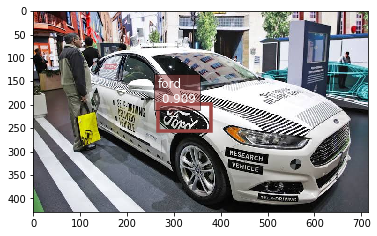

In [93]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img1.jpeg", mod);

heineken
 0.9663149118423462 [67.72882321102365, 203.75029882050472, 167.42414469678175, 333.82995421844345]
heineken
 0.8898571133613586 [146.2820188989874, 226.7006382354931, 219.4043661622426, 315.0177262578652]
['heineken\n', 0.9663149118423462, [67.72882321102365, 203.75029882050472, 167.42414469678175, 333.82995421844345]]


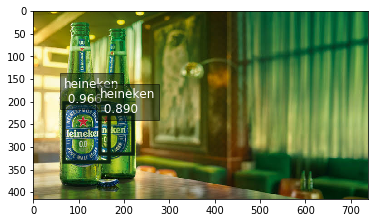

In [89]:
set_output_params(vis_thresh=0.8, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img2.jpeg", mod);

starbucks
 0.9954956769943237 [259.74820161654793, 120.31817195632209, 325.2618918502138, 163.54619253623304]
['starbucks\n', 0.9954956769943237, [259.74820161654793, 120.31817195632209, 325.2618918502138, 163.54619253623304]]


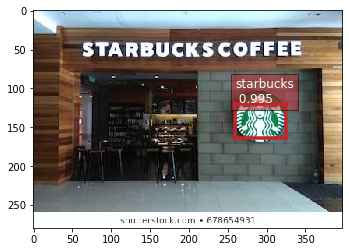

In [23]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img3.jpeg", mod);

dhl
 0.998580813407898 [197.12241285804222, 170.73891872737988, 327.6811156249858, 201.01083077734845]
['dhl\n', 0.998580813407898, [197.12241285804222, 170.73891872737988, 327.6811156249858, 201.01083077734845]]


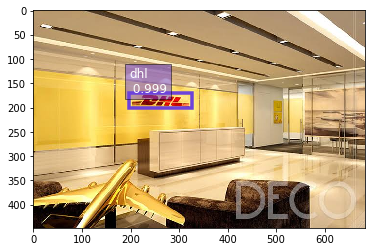

In [25]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img4.jpeg", mod);

cocacola
 0.9376248717308044 [451.4082762714814, 262.20659479962865, 528.5794671346099, 288.0345847326329]
['cocacola\n', 0.9376248717308044, [451.4082762714814, 262.20659479962865, 528.5794671346099, 288.0345847326329]]


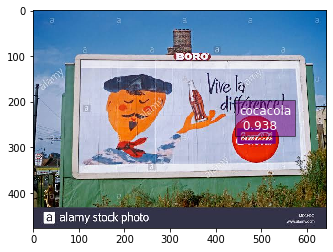

In [32]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img5.jpeg", mod);

accenture
 0.8399520516395569 [394.2023409485578, 153.92620824970118, 523.5065063936312, 177.63149229832436]
['accenture\n', 0.8399520516395569, [394.2023409485578, 153.92620824970118, 523.5065063936312, 177.63149229832436]]


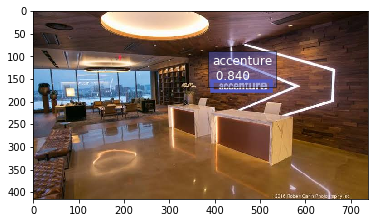

In [34]:
set_output_params(vis_thresh=0.8, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img6.jpeg", mod);

apple
 0.9389042258262634 [213.600122909542, 61.39711731601978, 294.19808238353465, 153.69647033384734]
['apple\n', 0.9389042258262634, [213.600122909542, 61.39711731601978, 294.19808238353465, 153.69647033384734]]


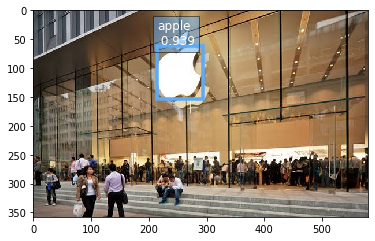

In [36]:
set_output_params(vis_thresh=0.55, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img7.jpeg", mod);

mcdonalds
 0.9995837807655334 [218.0800752919539, 113.26574395706635, 313.6876145454284, 190.57593603057657]
['mcdonalds\n', 0.9995837807655334, [218.0800752919539, 113.26574395706635, 313.6876145454284, 190.57593603057657]]


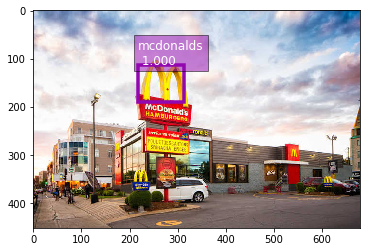

In [49]:
set_output_params(vis_thresh=0.6, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img8.jpeg", mod);

nike
 0.9610349535942078 [309.7998950551734, 44.91104176864264, 374.2266411166267, 128.45016293952094]
['nike\n', 0.9610349535942078, [309.7998950551734, 44.91104176864264, 374.2266411166267, 128.45016293952094]]


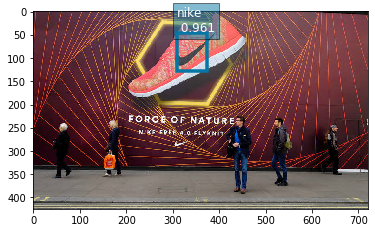

In [52]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img9.jpeg", mod);

olympics
 0.7452842593193054 [237.0624757977319, 79.36591530373622, 543.9553306056764, 274.09089779189105]
['olympics\n', 0.7452842593193054, [237.0624757977319, 79.36591530373622, 543.9553306056764, 274.09089779189105]]


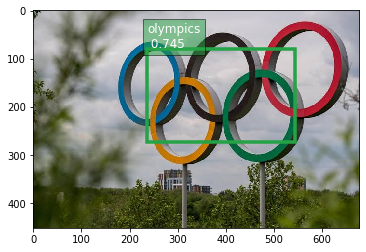

In [56]:
set_output_params(vis_thresh=0.74, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img10.jpeg", mod);

fedex
 0.9479970932006836 [102.89700245562561, 152.81695627642506, 182.04491487631554, 174.07579721667662]
['fedex\n', 0.9479970932006836, [102.89700245562561, 152.81695627642506, 182.04491487631554, 174.07579721667662]]


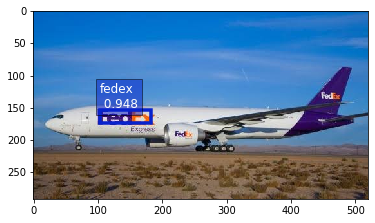

In [70]:
set_output_params(vis_thresh=0.74, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img11.jpeg", mod);

nvidia
 0.9979512095451355 [0.0, 114.17670142417595, 81.33919936304726, 175.46510567554174]
['nvidia\n', 0.9979512095451355, [0.0, 114.17670142417595, 81.33919936304726, 175.46510567554174]]


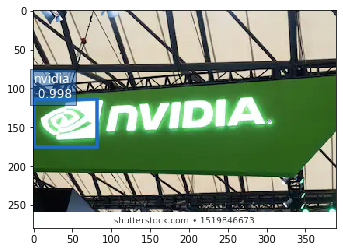

In [67]:
set_output_params(vis_thresh=0.74, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img12.jpg", mod);

maserati
 0.3151992857456207 [300.4731201171875, 112.7862548828125, 320.7750732421875, 159.748876953125]
['maserati\n', 0.3151992857456207, [300.4731201171875, 112.7862548828125, 320.7750732421875, 159.748876953125]]


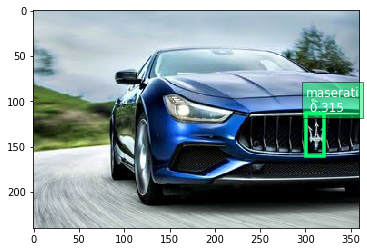

In [75]:
set_output_params(vis_thresh=0.2, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img13.jpeg", mod);

subway
 0.9220126271247864 [167.69653711857234, 48.632183483089996, 583.6046364482526, 105.22257215547458]
['subway\n', 0.9220126271247864, [167.69653711857234, 48.632183483089996, 583.6046364482526, 105.22257215547458]]


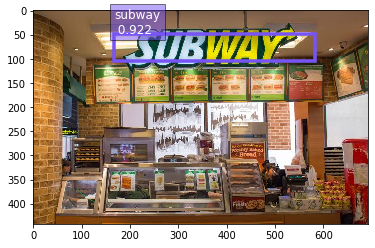

In [85]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img14.jpeg", mod);

nbc
 0.9935264587402344 [171.9844029548108, 42.364019716322126, 269.2134054122358, 112.87854980113283]
['nbc\n', 0.9935264587402344, [171.9844029548108, 42.364019716322126, 269.2134054122358, 112.87854980113283]]


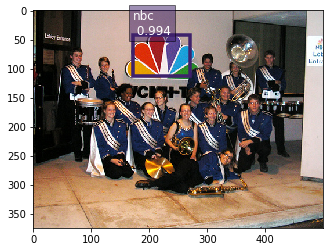

In [87]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/openlogo_test/img15.jpg", mod);